In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
img_left = cv2.imread( './stereo-imgs/im0.png', cv2.IMREAD_COLOR )
img_right = cv2.imread( './stereo-imgs/im1.png', cv2.IMREAD_COLOR )

(2000, 2856, 3)


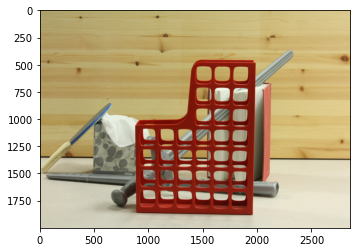

In [11]:
img_left_rgb = cv2.cvtColor( img_left, cv2.COLOR_BGR2RGB )
img_right_rgb = cv2.cvtColor( img_right, cv2.COLOR_BGR2RGB )
print(img_left.shape)
plt.imshow( img_left_rgb )
plt.show()

In [4]:
img_left_gray = cv2.cvtColor( img_left, cv2.COLOR_BGR2GRAY )
img_right_gray = cv2.cvtColor( img_right, cv2.COLOR_BGR2GRAY )

In [14]:
#stereoSGBM = cv2.StereoSGBM_create( numDisparities=32, blockSize=15 )
stereoBM = cv2.StereoBM_create( numDisparities=32, blockSize=15 )
window_size = 3
min_disp = 16
num_disp = 112-min_disp
stereoSGBM = cv2.StereoSGBM_create(minDisparity = min_disp,
    numDisparities = num_disp,
    blockSize = 11,
    P1 = 8*3*window_size**2,
    P2 = 32*3*window_size**2,
    disp12MaxDiff = 1,
    uniquenessRatio = 10,
    speckleWindowSize = 100,
    speckleRange = 32,
    mode=cv2.StereoSGBM_MODE_HH
)

disparitySGBM_left = stereoSGBM.compute( img_left_gray, img_right_gray ).astype( np.float32 ) / 16.0
disparitySGBM_right = stereoSGBM.compute( img_right_gray, img_left_gray ).astype( np.float32 ) / 16.0
disparityBM = stereoBM.compute( img_left_gray, img_right_gray )

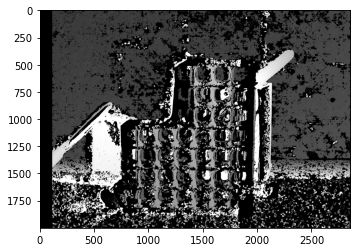

[[15. 15. 15. ... 15. 15. 15.]
 [15. 15. 15. ... 15. 15. 15.]
 [15. 15. 15. ... 15. 15. 15.]
 ...
 [15. 15. 15. ... 15. 15. 15.]
 [15. 15. 15. ... 15. 15. 15.]
 [15. 15. 15. ... 15. 15. 15.]]


In [15]:
#cv2.xim
plt.imshow( disparitySGBM_left, 'gray' )
plt.show()
print(disparitySGBM_left)

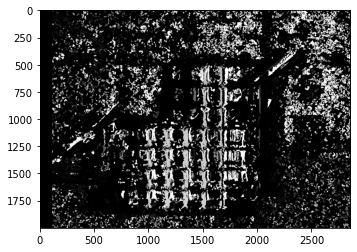

In [17]:
plt.imshow( disparitySGBM_right, 'gray' )
plt.show()

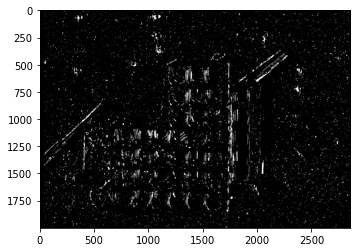

In [7]:
plt.imshow( disparityBM, 'gray' )
plt.show()

In [8]:
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

In [18]:
h, w = img_left.shape[:2]
f = 0.8*w                          
Q = np.float32([[1, 0, 0, -0.5*w],
                [0,-1, 0,  0.5*h], 
                [0, 0, 0,     -f], 
                [0, 0, 1,      0]])
points = cv2.reprojectImageTo3D(disparitySGBM_left, Q)
colors = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
mask = disparitySGBM_left > disparitySGBM_left.min()
out_points = points[mask]
out_colors = colors[mask]
out_fn = 'out.ply'
write_ply(out_fn, out_points, out_colors)